In [5]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchinfo import summary
from ptflops import get_model_complexity_info
import torch.nn as nn
import torch.optim as optim

import random
import torch.backends.cudnn as cudnn

import importlib
from dataclasses import dataclass

# files
import prepare_data
import model_lob
import embedding
import importlib
import util_lob

import train_epoch
import math

# util
from torch.utils.tensorboard  import SummaryWriter

import pandas as pd 


# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [6]:
@dataclass
class Arguments:
  # Data
  ticker: str = "SB"
  subticker: str = "1"
  year:str = "2021"
  data_folder: str = './data'
  batch_size: int = 64
  time_length: int = 100
  num_classes: int = 3
  horizon: int = 0 # horizon: 4 means position 5
  month: int = 5
  extra_month_train: int = 4
  extra_month_valid: int = 5
  extra_month_test: int = 5

  # Model
  model: str = 'vit'  # [lstm, gpt1]
  layers: int = 2
  block: str = 'prenorm'
  
  # CNN
  cnn_time_dropout = 0.1 #0.1
  cnn_dropout_prob = 0.1 #0.1
  init_dim = 7
  out_dim = init_dim * 7 # 40
  # hidden_dim=60
  # end_dim = 10
  
  # coef_AB = 1
  # coef_PV = 1
 
  # pv_dim = coef_PV * out_dim # 120
  # ab_dim = coef_AB * out_dim
    
  # Transformer
  # hidden_size = (pv_dim + ab_dim) * 10 // 2 # 768 or 40?
  hidden_size = init_dim * 4
  
  num_attention_heads = init_dim # each head is 64
  intermediate_size = math.floor(hidden_size * 4)
  hidden_dropout_prob = 0.1
  max_position_embeddings = 100
  
  # Optimization
  epochs: int = 10
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  lr: float =  7e-5 # 4e-3
  momentum: float = 0.9
  weight_decay: float =1e-4# 7e-3 # 5e-4

  # Experiment
  exp_id: str = 'debug'
  log: bool = True
  log_dir: str = './logs'
  seed: int = 8791321 # 186826 # 15796
  save_dir: str = './save'

  # Miscellaneous
  num_workers: int = 0
  device: str = "cuda:0" if torch.cuda.is_available() else "cpu"
  progress_bar: bool = False
  print_every: int = 100

In [7]:
configs = {
  1: Arguments(model='vit', log=True, optimizer='adamw'), # batch_size=128,
  2: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='momentum'),

  5: Arguments(model='vit', layers=4, batch_size=128, log=True, epochs=10, optimizer='adamw'),
  6: Arguments(model='vit', layers=6, batch_size=128, log=True, epochs=10, optimizer='adamw'),
  7: Arguments(model='vit', layers=6, batch_size=128, log=True, epochs=10, optimizer='adamw', block = 'postnorm')
#   7: python run_exp.py --model vit --layers 6 --batch_size 128  --epochs 10 --optimizer adamw --block postnorm
}
conf = configs[1]
device = conf.device

random.seed(conf.seed)
torch.manual_seed(conf.seed)

writer = SummaryWriter(log_dir=f'{conf.log_dir}/{conf.exp_id}')

Arguments(ticker='SB', subticker='1', year='2021', data_folder='./data', batch_size=64, time_length=100, num_classes=3, horizon=0, month=5, extra_month_train=4, extra_month_valid=5, extra_month_test=5, model='vit', layers=2, block='prenorm', epochs=10, optimizer='adamw', lr=7e-05, momentum=0.9, weight_decay=0.0001, exp_id='debug', log=True, log_dir='./logs', seed=8791321, save_dir='./save', num_workers=0, device='cuda:0', progress_bar=False, print_every=100)


In [ ]:
importlib.reload(prepare_data)
# https://stackoverflow.com/questions/37657939/oserror-269892000-requested-and-269188084-written
prepare_data.csv_to_npy(downsample_rows=100, span = 5,valid_days=3, test_days=3)

In [8]:
importlib.reload(prepare_data)
train_loader,val_loader,test_loader = prepare_data.sb(conf)

### class balances

In [9]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(6039, 525, 614)

In [19]:
b = train_loader.dataset.x.numpy()
b.shape

(6039, 1, 100, 40)

In [13]:
a = pd.DataFrame(np.array(train_loader.dataset.y))
a.value_counts(), a.value_counts() / len(a)

(2.0    2492
 0.0    2448
 1.0    1099
 dtype: int64,
 2.0    0.412651
 0.0    0.405365
 1.0    0.181984
 dtype: float64)

In [8]:
a_val = pd.DataFrame(np.array(val_loader.dataset.y))
a_val.value_counts(), a_val.value_counts()/len(a_val)

(2.0    2596
 0.0    2054
 1.0    1599
 dtype: int64,
 2.0    0.415426
 0.0    0.328693
 1.0    0.255881
 dtype: float64)

In [9]:
a_test = pd.DataFrame(np.array(test_loader.dataset.y))
a_test.value_counts(), a_test.value_counts()/len(a_test)

(0.0    2476
 2.0    2154
 1.0    1730
 dtype: int64,
 0.0    0.389308
 2.0    0.338679
 1.0    0.272013
 dtype: float64)

In [72]:
trainX_CNN = np.load(f"./data/{conf.ticker}/npy/1/{conf.ticker}_2021-06_train.npy")

# Model Architecture

In [60]:
importlib.reload(model_lob)
# model = model_lob.deeplob(y_len = dataset_train.num_classes)

model = model_lob.TransformerForSequenceClassfification(conf)
extractor = model_lob.CNNExtractor(conf)

# model = model_lob.Embeddings(conf)
# model = model_lob.TransformerEncoder(conf)
# model = model_lob.TransformerForSequenceClassfification(conf)

model.to(device)
extractor.to(device)

optimizer = train_epoch.get_optimizer(conf, model)
criterion = nn.CrossEntropyLoss()

Initialized VIT model with 117604 total parameters, of which 117604 are learnable.


In [7]:
macs, params = get_model_complexity_info(extractor, (1, 100, 40), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

CNNExtractor(
  93.86 k, 98.887% Params, 85.71 MMac, 100.000% MACs, 
  (conv_max_pool): MaxPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_avg_pool): AvgPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=(1, 2), stride=(1, 2), padding=0)
  (dim40_layers): dim40_layers(
    2.2 k, 2.316% Params, 4.42 MMac, 5.162% MACs, 
    (layer_1): LayerNorm(0, 0.000% Params, 0.0 Mac, 0.000% MACs, (40,), eps=1e-05, elementwise_affine=True)
    (layer_2): LayerNorm(0, 0.000% Params, 0.0 Mac, 0.000% MACs, (40,), eps=1e-05, elementwise_affine=True)
    (dilate_convs): ModuleList(
      2.18 k, 2.301% Params, 4.37 MMac, 5.096% MACs, 
      (0): layer_PV_dilate_40to40(
        364, 0.383% Params, 728.0 KMac, 0.849% MACs, 
        (conv_40To20_PaVaPbVbToPaPb123): Sequential(
          182, 0.192% Params, 364.0 KMac, 0.425% MACs, 
          (0): ZeroPad2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, (4, 4, 2, 0))
          

In [8]:
from ptflops import get_model_complexity_info

#! check dims!
macs, params = get_model_complexity_info(model, (1, 100, 40), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

TransformerForSequenceClassfification(
  113.27 k, 96.313% Params, 87.62 MMac, 100.000% MACs, 
  (encoder): TransformerEncoder(
    113.18 k, 96.239% Params, 87.62 MMac, 100.000% MACs, 
    (embeddings): Embeddings(
      93.86 k, 79.811% Params, 85.71 MMac, 97.820% MACs, 
      (token_embedding_CNN): CNNExtractor(
        93.86 k, 79.811% Params, 85.71 MMac, 97.820% MACs, 
        (conv_max_pool): MaxPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
        (conv_avg_pool): AvgPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=(1, 2), stride=(1, 2), padding=0)
        (dim40_layers): dim40_layers(
          2.2 k, 1.869% Params, 4.42 MMac, 5.049% MACs, 
          (layer_1): LayerNorm(0, 0.000% Params, 0.0 Mac, 0.000% MACs, (40,), eps=1e-05, elementwise_affine=True)
          (layer_2): LayerNorm(0, 0.000% Params, 0.0 Mac, 0.000% MACs, (40,), eps=1e-05, elementwise_affine=True)
          (dilate_convs): Mod

In [57]:
# summary(extractor,  (1, 1, 100, 40)),
summary(model,  (1,1, 100, 40))

(===============================================================================================
 Layer (type:depth-idx)                        Output Shape              Param #
 CNNExtractor                                  [1, 100, 28]              600
 ├─Sequential: 1-1                             [1, 1, 40, 100]           --
 │    └─LayerNorm: 2-1                         [1, 1, 40, 100]           200
 │    └─Linear: 2-2                            [1, 1, 40, 100]           10,100
 │    └─SiLU: 2-3                              [1, 1, 40, 100]           --
 │    └─Dropout: 2-4                           [1, 1, 40, 100]           --
 │    └─Linear: 2-5                            [1, 1, 40, 100]           10,100
 │    └─Dropout: 2-6                           [1, 1, 40, 100]           --
 │    └─SiLU: 2-7                              [1, 1, 40, 100]           --
 │    └─Linear: 2-8                            [1, 1, 40, 100]           10,100
 │    └─Dropout: 2-9                           [

# Model Training


In [61]:
importlib.reload(train_epoch)
importlib.reload(util_lob)
train_losses, val_losses, dt= train_epoch.batch_gd(model, writer, criterion, optimizer, train_loader, val_loader,  conf = conf)

  0%|          | 0/10 [00:00<?, ?it/s]

the 0 round and the train loss is 1.118576
the 2000 round and the train loss is 1.106781
Evaluating


 10%|█         | 1/10 [05:43<51:28, 343.21s/it]

0 result is saved
 best 0 result is saved
train logs saved
Epoch 1/10,             Train Loss: 1.1050,             Validation Loss: 1.0964,            Duration: 5.0,            Best Val Epoch: 0
the 0 round and the train loss is 1.091119
the 2000 round and the train loss is 1.098729
Evaluating


 20%|██        | 2/10 [11:24<45:34, 341.83s/it]

 best 1 result is saved
Epoch 2/10,             Train Loss: 1.0983,             Validation Loss: 1.0961,            Duration: 5.0,            Best Val Epoch: 1
the 0 round and the train loss is 1.088661
the 2000 round and the train loss is 1.095981
Evaluating


 30%|███       | 3/10 [16:53<39:13, 336.19s/it]

 best 2 result is saved
train logs saved
Epoch 3/10,             Train Loss: 1.0959,             Validation Loss: 1.0912,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.092233
the 2000 round and the train loss is 1.094301
Evaluating


 40%|████      | 4/10 [22:22<33:19, 333.29s/it]

Epoch 4/10,             Train Loss: 1.0942,             Validation Loss: 1.0920,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.098003
the 2000 round and the train loss is 1.092932
Evaluating


 50%|█████     | 5/10 [27:48<27:32, 330.59s/it]

train logs saved
Epoch 5/10,             Train Loss: 1.0931,             Validation Loss: 1.0950,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.106890
the 2000 round and the train loss is 1.091893
Evaluating


 60%|██████    | 6/10 [33:08<21:48, 327.18s/it]

5 result is saved
Epoch 6/10,             Train Loss: 1.0919,             Validation Loss: 1.0919,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.056888
the 2000 round and the train loss is 1.091128
Evaluating


 70%|███████   | 7/10 [38:30<16:16, 325.41s/it]

train logs saved
Epoch 7/10,             Train Loss: 1.0909,             Validation Loss: 1.0914,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.066918
the 2000 round and the train loss is 1.089954
Evaluating


 80%|████████  | 8/10 [43:49<10:46, 323.38s/it]

Epoch 8/10,             Train Loss: 1.0899,             Validation Loss: 1.0918,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.052565
the 2000 round and the train loss is 1.088856
Evaluating


 90%|█████████ | 9/10 [49:30<05:28, 328.95s/it]

train logs saved
Epoch 9/10,             Train Loss: 1.0892,             Validation Loss: 1.0936,            Duration: 5.0,            Best Val Epoch: 2
the 0 round and the train loss is 1.081633
the 2000 round and the train loss is 1.087655
Evaluating


100%|██████████| 10/10 [55:02<00:00, 330.24s/it]

Epoch 10/10,             Train Loss: 1.0883,             Validation Loss: 1.0942,            Duration: 5.0,            Best Val Epoch: 2


In [49]:
model.eval()
n_correct = 0.
n_total = 0.

all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

print(f"Test acc: {test_acc:.4f}")
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

Test acc: 0.8746
accuracy_score: 0.8746343771507227
              precision    recall  f1-score   support

           0     0.9058    0.6185    0.7350     21127
           1     0.8741    0.9717    0.9203     98602
           2     0.8494    0.6640    0.7453     19759

    accuracy                         0.8746    139488
   macro avg     0.8764    0.7514    0.8002    139488
weighted avg     0.8754    0.8746    0.8675    139488



### Experiment results




 #* RuntimeError: DataLoader worker (pid(s) 42700, 43016, 38164, 40812, 38648, 29288, 13532) exited unexpectedly  
#* Caused by num_worker too high https://github.com/pytorch/pytorch/issues/5301  
#! Brand new design! Smooth over time + FFN -> smooth over levels + FFN -> stack LV,P,V together -> run one convmix block  
#! 6 min per round  
#* self.h = 60, lstm = 48  


#! Original Test acc: 0.7535  
#! Depthwise + pointwise 0.6595  
#! ori layout + only depthwise + pointwise: 0.7584  
#! dilation with small kernel: 0.7594  
#! dilation with small kernel + large kernel: 0.7520 :small kernel is easy to over fit  
#! same as above but with replication padding : 0.67 (10th) and 0.7395 (best)  
#! only dilation on time and   
#! back to silu, only one dilation block, separable (3,8) blocks again, and avg adap pooling everywhere, lr 001, change depthwise to 2d kernel, and change dilation to one convo (no depth + point)  
#! change adaptive pooling to hand designed 0.7483 (50th) and (0.7463)  
#! channel = 64 -> last(0.68) best(0.6878)  
#! change back to (7,7) kernels -> last(0.6251) best(0.6968) and no avg pooling lr 0.004  
#! all to layernorm and only 5 prenorm blocks(with ffn) and dropout (0.1) everywhere (0.7246) last and best (0.73)  
#! smoothed model: 0.8948  
#! more complex smoothed model: 0.8925  
#! Best smooth model 0.9159 k =4;      0.7428 k =3     k=1 0.7373;   
#! transformer model: best k=4 - 92%; k =3 - 87% k=2 0.8185 / 0.8176 (AB no cat)  /0.8174(AB with cat last) 0.8282(Best) Brand new model (with transposed convolution and PV injection into AB route) (0.79)   
#! simplified model: Pa, Va, Pb, Vb concatenate: 0.8328 0.8346 (10 more rounds) 0.8321 (layer = 4) 0.9243 (when k = 4)

### Continue

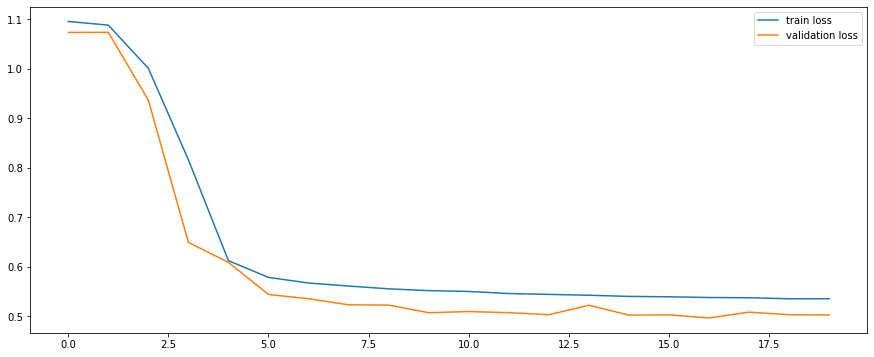

In [14]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

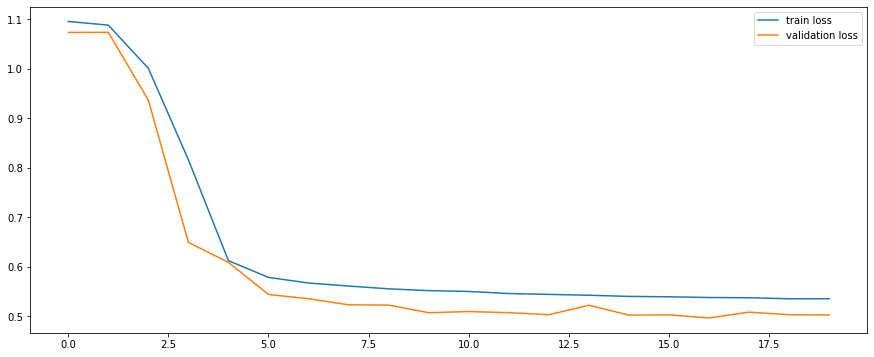

In [15]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# Model Testing

In [92]:
dict = {'train_losses': train_losses, 
'val_losses': val_losses, 
'train_time': dt,}  
df = pd.DataFrame(dict) 
df.to_csv(f'{conf.log_dir}/{conf.exp_id}/train_simp_model.csv') 

In [90]:
util_lob.save_train_logs(
        conf,train_losses, val_losses, dt
    )

train logs saved


In [47]:
list(test_loader.dataset)[3761]

(tensor([[[2.1913, 0.1245, 2.1895,  ..., 0.1268, 2.1737, 0.1219],
          [2.1913, 0.1245, 2.1895,  ..., 0.1268, 2.1737, 0.1219],
          [2.1913, 0.1245, 2.1860,  ..., 0.1268, 2.1701, 0.1214],
          ...,
          [2.2036, 0.1263, 2.2018,  ..., 0.1289, 2.1860, 0.1237],
          [2.2053, 0.1266, 2.2018,  ..., 0.1291, 2.1860, 0.1237],
          [2.2036, 0.1263, 2.2018,  ..., 0.1291, 2.1860, 0.1237]]]),
 nan)

In [149]:
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
# torch.save(model, './model/best_model.pt')
torch.save(model.state_dict(), './state_dict/transformer_50rounds_k4.pt')
# model = torch.load('./model/best_model.pt')

# model = Net()
model.load_state_dict(torch.load('./state_dict/best_val_model_pytorch.pt'))

torch.load(f'{conf.save}/checkpoint_{epoch:04d}.pth.zip', )

In [ ]:
torch.load(f'{conf.save}/checkpoint_0010.pth.zip', )

In [118]:
model = model_lob.TransformerForSequenceClassfification(conf).to(device=device)
optimizer = train_epoch.get_optimizer(conf, model)

# checkpoint = torch.load(f"./{conf.save_dir}/{conf.exp_id}/checkpoint_0010.pth.zip")
checkpoint = torch.load(f"./{conf.save_dir}/{conf.exp_id}/model_best.pth.zip")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

Initialized VIT model with 109111 total parameters, of which 109111 are learnable.


In [36]:
report_dict = classification_report(all_targets, all_predictions, digits=4, output_dict=True)
pd.DataFrame(report_dict).transpose()

,precision,recall,f1-score,support
0,0.843040,0.694964,0.761874,31888.000000
1,0.816335,0.937341,0.872663,78297.000000
2,0.857198,0.681534,0.759339,29303.000000
accuracy,0.828193,0.828193,0.828193,0.828193
macro avg,0.838858,0.771280,0.797959,139488.000000
weighted avg,0.831025,0.828193,0.823529,139488.000000
